In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the clean data into variables
DataPath = "Processed Data/"

dicts = ['EFI_ID_List', 'metabolite_dict', 'Protein_seq_dict']

with open(DataPath + 'EFI_ID_List.p', 'rb') as EFI_ID:
    EFI_ID_List = pickle.load(EFI_ID)

with open(DataPath + 'metabolite_dict.p', 'rb') as metabolite:
    metabolite_dict = pickle.load(metabolite)

with open(DataPath + 'Protein_seq_dict.p', 'rb') as Protein_seq:
    Protein_seq_dict = pickle.load(Protein_seq)

activations = pd.read_csv(DataPath + 'activations.csv', index_col=0)

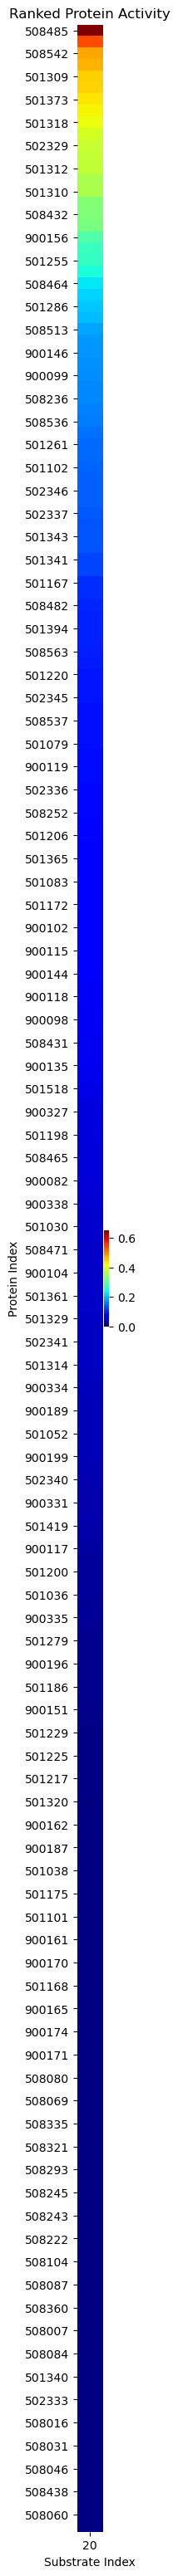

In [120]:
def Heatmap(df=activations, xlabel="Protein Index", ylabel="Substrate Index", dpi=400):
    # Generate heatmap of raw data and activations
    plt.figure(dpi=dpi)
    heatmap = plt.imshow(df) # Creates heatmap using input dataframe/array
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.jet() # Specifies the "jet" colormap
    plt.colorbar() # Displayes colourbar
    plt.show(heatmap)
    plt.close()

def Heatmap_Vector(df=activations.iloc[0,:], ylabel="Protein Index", xlabel="Substrate Index", my_dpi=100):
    # Generate heatmap from data contained in a vector using seaborn
    plt.figure(figsize=(0.5,40), dpi=my_dpi)
    ax = sns.heatmap(df_view, cmap='jet', linewidths=0)
    
    ax.set(title='Ranked Protein Activity',
            xlabel=xlabel,
            ylabel=ylabel)
    
    plt.show(ax)
    plt.close()

def SortNormalize(df):
    df = df.sort_values(by=SID, ascending=False) # Sort values in descending order
    print(df[df[SID] > 0].count()) # Print count of non-zero datapoints

Heatmap_Vector(pd.DataFrame(activations.iloc[0,:]))

In [ ]:
def AnalyzeSubstrate(df=activations, SID=0):
    df = pd.DataFrame(df.iloc[SID,:]) # Obtains vector from dataframe
    

20
20    161
dtype: int64


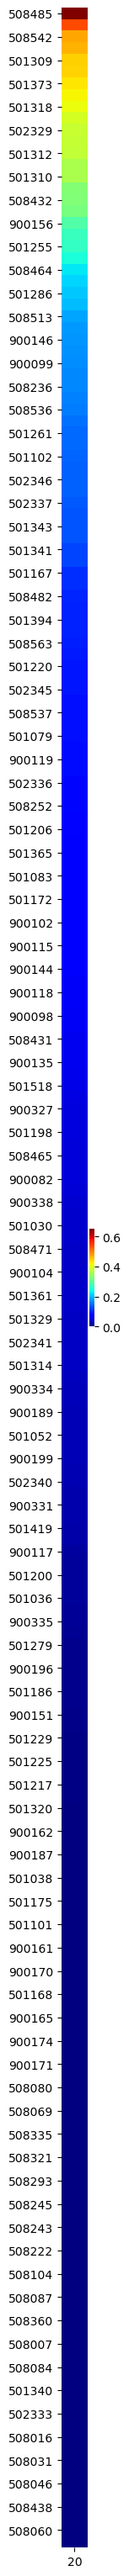

In [109]:
SID = np.random.randint(0,168)
print(SID)

df_view = pd.DataFrame(activations.iloc[SID,:]) # Obtains vector from dataframe
df_view = df_view.sort_values(by=SID, ascending=False) # Sort values in descending order
print(df_view[df_view[SID] > 0].count()) # Print count of non-zero datapoints




In [71]:
df_view

,0
501392,0.9825
900327,0.6505
508016,0.4290
900334,0.4165
900159,0.3190
...,...
502331,0.0000
900162,0.0000
501163,0.0000
900117,0.0000
